In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
from scipy import stats
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                     encoding = 'UTF-8')
data = data[data['add'] == '서울']
rain = data[['date', 'sum_rn']]
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957 entries, 0 to 3956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   sum_rn  3957 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.7+ KB


            sum_rn
date              
2012-01-01     0.0
2012-01-02     0.0
2012-01-03     0.0
2012-01-04     0.0
2012-01-05     0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


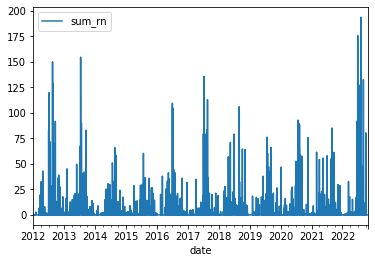

In [4]:
rain['date'] = pd.to_datetime(rain['date'])
rain = rain.set_index('date')
print(rain.head())
rain.plot()

In [9]:
def tsplot(y, lags=None, figsize=(13, 8), style='bmh', title="Time Series Analysis Plots"):
    y = y.values
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    if not isinstance(title, str):
        title = str(title)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        _ = plt.xticks(np.arange(0, len(y), step=24))
        
        acf_ax = plt.subplot2grid(layout, (1, 0))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
 
    return plt.show()

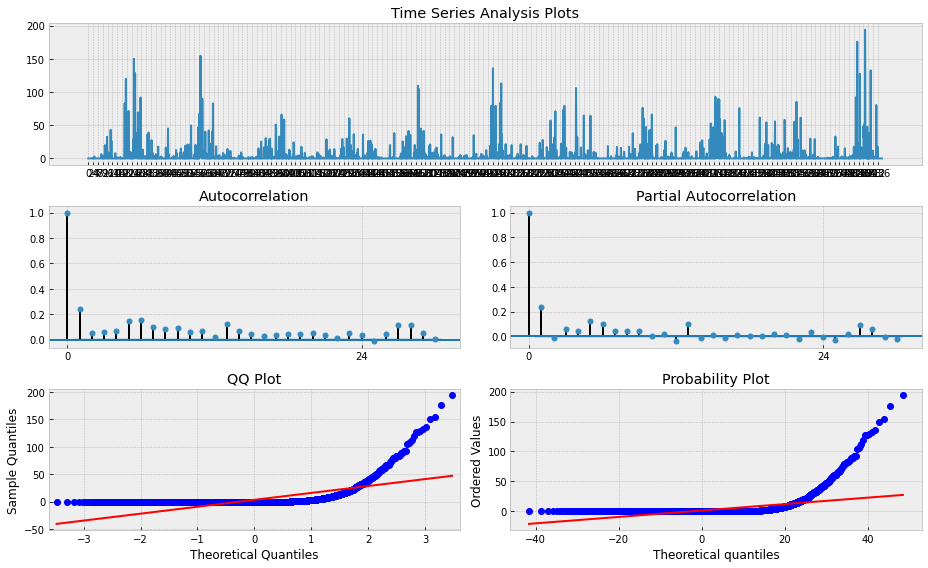

In [11]:
tsplot(rain['sum_rn'], lags = 30)

In [15]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.2 MB/s 


In [17]:
from arch import arch_model
am = arch_model(rain)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23502.467739481064
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19787.680373558047
Iteration:      3,   Func. Count:     22,   Neg. LLF: 15310.086489746078
Iteration:      4,   Func. Count:     30,   Neg. LLF: 14503.616896532585
Iteration:      5,   Func. Count:     35,   Neg. LLF: 14504.359652918338
Iteration:      6,   Func. Count:     41,   Neg. LLF: 14502.380202143777
Iteration:      7,   Func. Count:     46,   Neg. LLF: 14502.257622590734
Iteration:      8,   Func. Count:     51,   Neg. LLF: 14502.25693897336
Iteration:      9,   Func. Count:     56,   Neg. LLF: 14502.256936890011
Iteration:     10,   Func. Count:     60,   Neg. LLF: 14502.256926039301
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14502.256936890011
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results     

In [18]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [26]:
log_rain = np.log((rain+1)/(rain+1).shift(1)).dropna()

In [27]:
log_rain

,sum_rn
date,
2012-01-02,0.0
2012-01-03,0.0
2012-01-04,0.0
2012-01-05,0.0
2012-01-06,0.0
...,...
2022-10-27,0.0
2022-10-28,0.0
2022-10-29,0.0


In [28]:
res_tup = _get_best_model(log_rain)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

aic: 10779.29 | order: (3, 0, 4)


In [29]:
order = res_tup[1]
model = res_tup[2]

In [32]:
from statsmodels.tsa import arima_model
model = arima_model(rain, (3,0,4))

TypeError: ignored

In [ ]:
tsplot(model.resid , lags = 30)

In [12]:
arch_model(rain)

NameError: ignored